In [1]:
## Homework 5

In [3]:
import pandas as pd
import tqdm
import py2neo
import itertools
import seaborn as sns
import pandas as pd

graph = py2neo.Graph("bolt:://localhost:7687", auth=("neo4j", "password4j"), name="neo4j")
target = pd.read_csv('/Users/zac/Downloads/FR_target.csv')
edges = pd.read_csv('/Users/zac/Downloads/FR_edges.csv')

In [ ]:
# 1) Give the IDs of the top 10 streamers that have atleast one collaboration.

try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")
  
transaction_list = []

iteration = 0
for row in tqdm.tqdm(target.iterrows()):
    id_ = row[1]["id"]
    views = row[1]["views"] 
    days = row[1]["days"]
    mature = row[1]["mature"] 
    new_id = row[1]["new_id"]
    partner = row[1]["partner"] 
    transaction_list.append({"id_":id_,"views":views,"days":days,"mature":mature,"new_id":new_id,"partner":partner})
    iteration += 1
    if iteration % 1000 == 0:
        transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []
        
graph.run(transaction, json=transaction_list)

In [59]:
transaction_list = []


transaction = """UNWIND $json as data
MATCH (a:Streamer),(b:Streamer)
WHERE a.new_id = data.from AND b.new_id = data.to
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for edge in tqdm.tqdm(edges.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)

100%|████████████████████████████████████████████████████████████████████████████| 5882/5882 [2:49:18<00:00,  1.73s/it]


(No data)

In [60]:
query = """MATCH (video:Streamer)
WHERE exists(video.id_)
RETURN video
ORDER BY video.views DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["video"])

[Node('Streamer', days=1372, id_=79360207, mature=False, new_id=4900, partner=True, views=26710589),
 Node('Streamer', days=228, id_=198506129, mature=False, new_id=5516, partner=True, views=23653368),
 Node('Streamer', days=2478, id_=27115917, mature=False, new_id=142, partner=True, views=9524566),
 Node('Streamer', days=2853, id_=18887776, mature=True, new_id=5310, partner=True, views=9194058),
 Node('Streamer', days=2430, id_=28269648, mature=False, new_id=2898, partner=True, views=7387278),
 Node('Streamer', days=1676, id_=58619946, mature=False, new_id=5684, partner=True, views=5011064),
 Node('Streamer', days=2133, id_=38350595, mature=False, new_id=4719, partner=True, views=4831573),
 Node('Streamer', days=1806, id_=50926401, mature=False, new_id=1939, partner=True, views=4135662),
 Node('Streamer', days=2280, id_=32042515, mature=True, new_id=4627, partner=True, views=4128354),
 Node('Streamer', days=1991, id_=43043577, mature=True, new_id=1100, partner=True, views=4009806)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


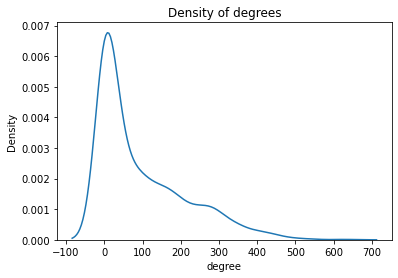

In [61]:
# 2. Create a density of node degrees.Do you observe a power scale law? what does it mean?

query =  """
MATCH (p)
WITH p, size((p)-[:RELATION]->()) as degree
RETURN degree;
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")

In [62]:
# 3. How many streamers has the tag "mature"?

query = """ MATCH (video:Streamer) WHERE video.mature=true with count(video) as n RETURN n """
graph.run(query)

n
361


In [63]:
# 4. Is the collaboration correlated to the "mature" tags?

query = """MATCH (video:Streamer)-[r:RELATION]->(n_collab)  where video.mature = TRUE  RETURN video.mature """
graph.run(query)

video.mature
true
true
true


In [64]:
# 5. Do partners collaborate more than non partners ?

query="""
MATCH (video:Streamer)
WHERE video.partner=true
with count(video) as n
RETURN n
"""
graph.run(query)
query1="""MATCH (video:Streamer) WHERE video.partner=false with count(video) as n RETURN n """
graph.run(query1) 

n
931
